In [1]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd 'gdrive/MyDrive/Colab Notebooks/Deep Learning/Final Project'

/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Final Project


In [ ]:
# Install detectorn 2
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.5'

# install requirements
!pip install transformers

In [10]:
# import libraries
from v_embed import visual_embeddings
import pandas as pd
import torch
import cv2
import os
import numpy as np

# import torch libraries
from torch.utils.data import DataLoader, Dataset, TensorDataset
from transformers import BertTokenizer, BertModel, VisualBertModel

In [11]:
# Read train json file
df_train = pd.read_json("train.jsonl", lines=True)
df_captions = pd.read_csv("resultsWithImageId.csv", header=None)
df_captions.columns = ["img", "caption"]

In [8]:
df_train

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."
...,...,...,...,...
8495,10423,img/10423.png,1,nobody wants to hang auschwitz me
8496,98203,img/98203.png,1,when god grants you a child after 20 years of ...
8497,36947,img/36947.png,1,gays on social media: equality! body positivit...
8498,16492,img/16492.png,1,having a bad day? you could be a siamese twin ...


In [12]:
df_captions

,img,caption
0,img/42953.png,black and white portrait of a handsome man.
1,img/23058.png,you're never too old to be a married man.
2,img/13894.png,"person, the cat of person."
3,img/37408.png,"the dog nanny, dog sitter."
4,img/82403.png,love is like a chocolate cake.
...,...,...
8495,img/10423.png,let's talk about the problem of the people.
8496,img/98203.png,a man holds up a burning flag during a protest...
8497,img/36947.png,actor at the premiere of romantic comedy film.
8498,img/16492.png,person - when you're the only person in the wo...


In [13]:
df_data = pd.merge(df_train, df_captions, on='img')

In [14]:
df_dev = pd.read_json('dev.jsonl', lines=True)
df_dev_captions = pd.read_csv("results_dev.csv", header=None)
df_dev_captions.columns = ["img", "caption"]
# df_test = pd.read_json('test.jsonl', lines=True)

df_dev_data = pd.merge(df_dev, df_dev_captions, on='img')

In [ ]:
df_dev_data

,id,img,label,text,caption
0,8291,img/08291.png,1,white people is this a shooting range,there's nothing wrong with a child shooting a ...
1,46971,img/46971.png,1,bravery at its finest,"i'm not a pacifist, i'm a soldier."
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...,customer service at a fast food restaurant.
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...,close - up of a gladiator's helmet.
4,80243,img/80243.png,1,mississippi wind chime,i used to live in the windmills.
...,...,...,...,...,...
495,83675,img/83675.png,0,i'm gonna be like phelps one day,person in the swimming pool.
496,37198,img/37198.png,0,when you're so relaxed you can feel yourself g...,woman lying on the grass at the edge of the pool.
497,48670,img/48670.png,0,look at this sandwich maker club i found on wi...,i made a toast to someone who left a loaf of b...
498,9863,img/09863.png,0,diverse group of women,group of women in a circle.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_folder = "hateful_memes/"
cfg_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

# Load bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
visual_obj = visual_embeddings(cfg_path)

# Load BERT and VisualBERT model
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
visualbert_model = VisualBertModel.from_pretrained('uclanlp/visualbert-nlvr2-coco-pre').to(device)

In [ ]:
class MyDataset(Dataset):
    def __init__(self,df_data, data_folder=data_folder, tokenizer=tokenizer, visual_obj=visual_obj, bert_model=bert_model, visualbert_model=visualbert_model):
        self.img = df_data['img'].values
        self.text = df_data['text'].values
        self.caption = df_data['caption'].values
        self.y = df_data['label'].values
        self.data_folder = data_folder
        self.tokenizer = tokenizer
        self.visual_obj = visual_obj
        self.bert_model = bert_model
        self.visualbert_model = visualbert_model
        self.device = device

    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        # Send the image caption to bert model to get text representation
        caption_embed = self.bert_model(**self.tokenizer(self.caption[idx], max_length=128, padding='max_length', truncation=True, return_tensors='pt').to(self.device)).pooler_output

        # Convert meme text to tokens using BERT tokenizer
        meme_tokens = self.tokenizer(self.text[idx], max_length=128, padding='max_length', truncation=True, return_tensors='pt')

        # read image from data folder
        image_bgr = cv2.imread(os.path.join(self.data_folder, self.img[idx]))

        # get visual embedding of the image frro, detectron2
        visual_embeds = torch.stack(self.visual_obj.get_visual_embeds([image_bgr], 1))
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

        # Update visual embeddings of the corresponding image to their respective text embeddings
        meme_tokens.update(
            {
                "visual_embeds": visual_embeds,
                "visual_token_type_ids": visual_token_type_ids,
                "visual_attention_mask": visual_attention_mask,
            }
        )

        # Get pooler output from the VisualBERT model using the text and visual embeddings
        meme_embed = self.visualbert_model(**meme_tokens.to(self.device)).pooler_output

        # concatenate the caption embedding and meme embeddings from BERT and VisualBERT
        # respectively as a feature vector to train fully connected model
        return torch.cat([caption_embed, meme_embed], axis=1), torch.Tensor([self.y[idx]]).to(self.device)

In [ ]:
train_dataset = MyDataset(df_data=df_data)
# test_dataset = MyDataset(df_data=df_dev_data)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=4)
# test_dataloader = DataLoader(test_dataset, batch_size=4)

In [ ]:
# Pytorch model
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # the final concatenated feature will be a vector of size 1536
        self.fc1 = torch.nn.Linear(1536,256)
        self.fc2 = torch.nn.Linear(256,32)
        self.fc3 = torch.nn.Linear(32,1)
        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
model = NeuralNetwork().to(device)

In [ ]:
model

NeuralNetwork(
  (fc1): Linear(in_features=1536, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
# A simple fully connected network is used to train the model on generated feature vectors
from torchsummary import summary
summary(model, (1,1536))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         393,472
           Dropout-2               [-1, 1, 256]               0
            Linear-3                [-1, 1, 32]           8,224
           Dropout-4                [-1, 1, 32]               0
            Linear-5                 [-1, 1, 1]              33
Total params: 401,729
Trainable params: 401,729
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 1.53
Estimated Total Size (MB): 1.54
----------------------------------------------------------------


In [ ]:
batch_size = 64
num_epochs = 10
learning_rate = 0.000001

In [ ]:
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# Given ground truth and predictions from the  model return the accuracy of the model and the auroc score
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    # aucroc = roc_auc_score(y_train.detach().cpu().numpy(),y_pred_tag.squeeze(1).detach().cpu().numpy())
    return acc#, aucroc

In [ ]:
train_data = np.load('data.npy')
train_label = np.load('label.npy')

In [ ]:
train_dataset = TensorDataset(torch.Tensor(train_data), torch.Tensor(train_label))

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

In [ ]:
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_acc = 0.0

    # load the dataset as batches
    for batch_no,(x_train,y_train) in enumerate(train_dataloader):
        x_train = x_train.to('cuda')
        y_train = y_train.to('cuda')
        optimizer.zero_grad()
        y_pred = model(x_train)

        #calculate loss
        loss = criterion(y_pred, y_train.unsqueeze(1))
        acc = binary_acc(y_pred, y_train.unsqueeze(1))

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    print(f'Epoch {epoch+0:03}: | Loss: {epoch_loss/len(train_dataloader):.5f} | Acc: {epoch_acc/len(train_dataloader):.3f}')

Epoch 000: | Loss: 0.67944 | Acc: 63.827
Epoch 001: | Loss: 0.67926 | Acc: 63.880
Epoch 002: | Loss: 0.67937 | Acc: 63.910
Epoch 003: | Loss: 0.67942 | Acc: 63.835
Epoch 004: | Loss: 0.67904 | Acc: 63.917
Epoch 005: | Loss: 0.67924 | Acc: 63.880
Epoch 006: | Loss: 0.67925 | Acc: 63.820
Epoch 007: | Loss: 0.67943 | Acc: 63.880
Epoch 008: | Loss: 0.67920 | Acc: 63.947
Epoch 009: | Loss: 0.67888 | Acc: 63.880


In [ ]:
y_pred.squeeze(1).detach().cpu().numpy()[0]

array([-0.08718485], dtype=float32)

In [ ]:
binary_acc(y_pred, y_train.unsqueeze(1))

In [ ]:
_, img_path, label, text, caption = df_data.loc[df_data['img']=='img/03854.png'].iloc[0]
# img_path = 'hateful_memes/' + img_path

In [ ]:
self=train_dataset
caption_embed = self.bert_model(**self.tokenizer(caption, max_length=128, padding='max_length', truncation=True, return_tensors='pt').to(self.device)).pooler_output
meme_tokens = self.tokenizer(text, max_length=128, padding='max_length', truncation=True, return_tensors='pt')

image_bgr = cv2.imread(os.path.join(self.data_folder, img_path))
visual_embeds = torch.stack(self.visual_obj.get_visual_embeds([image_bgr], 1))
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

meme_tokens.update(
    {
        "visual_embeds": visual_embeds,
        "visual_token_type_ids": visual_token_type_ids,
        "visual_attention_mask": visual_attention_mask,
    }
)

meme_embed = self.visualbert_model(**meme_tokens.to(self.device)).pooler_output

In [ ]:
x, y = torch.cat([caption_embed, meme_embed], axis=1).detach().cpu().numpy(), torch.Tensor([label]).to(self.device).detach().cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt

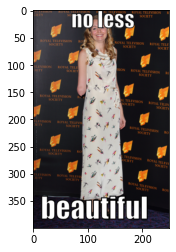

In [ ]:
img = plt.imread(data_folder + img_path)
plt.imshow(img)

In [ ]:
text, caption

('no less beautiful', 'actor at the premiere screening of film... picture.')